In [2]:
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.sample import fast_sampler
from SALib.sample import latin
from SALib.analyze import sobol
from SALib.analyze import fast
from SALib.analyze import rbd_fast

from SALib.test_functions import Ishigami
import numpy as np
import pandas as pd

In [3]:
df_sims = pd.read_csv('/home/disk/eos8/ach315/upscale/data/sims_6105.csv', dtype={'site':'str'})

# 2. site & site-years
df_sites_all = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_summary.csv', dtype={'site': str})
siteyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_filtered.csv', dtype={'site':str})
df_sites = df_sites_all[df_sites_all.site.isin(siteyears.site)]
df_sites.reset_index(inplace=True, drop=True)

# 3. weather
df_wea = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', dtype={'site': 'str'}, index_col=0)
df_wea.reset_index(inplace=True, drop=True)

# 4. parameter
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/params/param_opt.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)
df_params['cvar'] = df_params.index

# 5. merge all
df_sims_params = pd.merge(df_sims, df_params, on='cvar')
df_sims_params_sites = pd.merge(df_sims_params, df_sites, on='site')
df_all = pd.merge(df_sims_params_sites, df_wea, on=['site','year'])


In [4]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/params/param_opt.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)
df_params.head()

,juv_leaves,stayGreen,rmax_ltir,phyllo,LM_min,Vcmax,Vpmax,g1,ref_potential
0,23,4.44,1.24,3.31,98.77,77.29,92.57,9.86,-3.38
1,16,7.13,0.55,3.98,89.85,67.10,87.81,1.37,-2.83
2,21,6.51,1.00,3.04,81.24,66.65,81.56,3.88,-2.63
3,24,4.67,0.68,3.24,97.70,69.56,69.67,4.86,-3.63
4,20,4.32,0.82,3.13,115.08,64.44,101.27,6.31,-3.40


In [4]:
problem = {
    'num_vars': 9,
    'names': ['juv_leaves', 
              'stayGreen', 
              'rmax_ltir', 
              'phyllo', 
              'LM_min', 
              'Vcmax', 
              'Vpmax', 
              'g1',
              'ref_potential'],
    'bounds': [[15,25],
               [3,8],
               [0.5, 1.5],
               [2,4],
               [80,120],
               [60,80],
               [60,120],
               [1,10],
               [-4,-1]
              ]
}

In [7]:
ear = df_all.groupby('cvar').mean().dm_ear

X = df_params.to_numpy()
Y = np.array(ear)
Si = rbd_fast.analyze(problem, X, Y, print_to_console=False)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

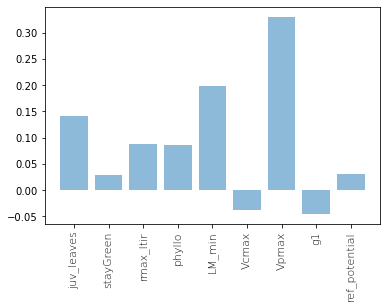

In [21]:
plt.bar(Si['names'], Si['S1'], alpha=0.5)
plt.xticks(rotation=90, fontsize=11, weight='light')

In [18]:
problem = {
    'num_vars': 13,
    'names': ['juv_leaves', 
              'stayGreen', 
              'rmax_ltir', 
              'phyllo', 
              'LM_min', 
              'Vcmax', 
              'Vpmax', 
              'g1',
              'ref_potential',
              'temp',
              'vpd',
              'precip',
              'solrad'],
    'bounds': [[15,25],
               [3,8],
               [0.5, 1.5],
               [2,4],
               [80,120],
               [60,80],
               [60,120],
               [1,10],
               [-4,-1],
               [df_wea.temp.min(), df_wea.temp.max()],
               [df_wea.vpd.min(), df_wea.vpd.max()],
               [df_wea.precip.min(), df_wea.precip.max(),
               [df_wea.solrad.min(), df_wea.solrad.max()]]
              ]
}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

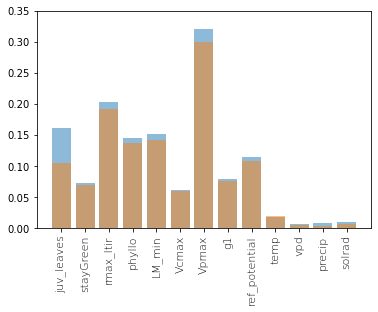

In [21]:
# average across all years
ear = df_all.groupby(['cvar', 'site']).mean().dm_ear
df_params_all = df_all.groupby(['cvar', 'site']).mean().loc[:, ['juv_leaves','stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
                                                                'Vcmax', 'Vpmax', 'g1', 'ref_potential', 
                                                                'temp', 'vpd', 'precip', 'solrad']]
X = df_params_all.to_numpy()
Y = np.array(ear)
Si = rbd_fast.analyze(problem, X, Y, print_to_console=False)

plt.bar(Si['names'], Si['S1'], alpha=0.5)
plt.ylim(0, 0.35)
plt.xticks(rotation=90, fontsize=11, weight='light')


# using all data
ear = df_all.dm_ear
df_params_all = df_all.loc[:, ['juv_leaves','stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
                               'Vcmax', 'Vpmax', 'g1', 'ref_potential', 
                               'temp', 'vpd', 'precip', 'solrad']]
X = df_params_all.to_numpy()
Y = np.array(ear)
Si = rbd_fast.analyze(problem, X, Y, print_to_console=False)

plt.bar(Si['names'], Si['S1'], alpha=0.5)
plt.xticks(rotation=90, fontsize=11, weight='light')

In [10]:
ear = df_all.dm_ear
df_params_all = df_all.loc[:, ['juv_leaves','stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
                               'Vcmax', 'Vpmax', 'g1', 'ref_potential', 
                               'temp', 'vpd', 'precip', 'solrad']]
X = df_params_all.to_numpy()
Y = np.array(ear)
Si = rbd_fast.analyze(problem, X, Y, print_to_console=False)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

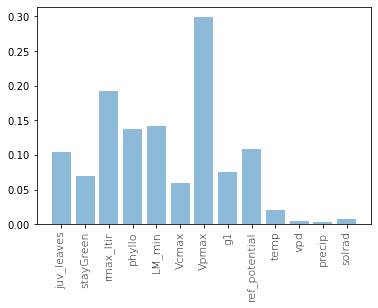

In [11]:
plt.bar(Si['names'], Si['S1'], alpha=0.5)
plt.xticks(rotation=90, fontsize=11, weight='light')

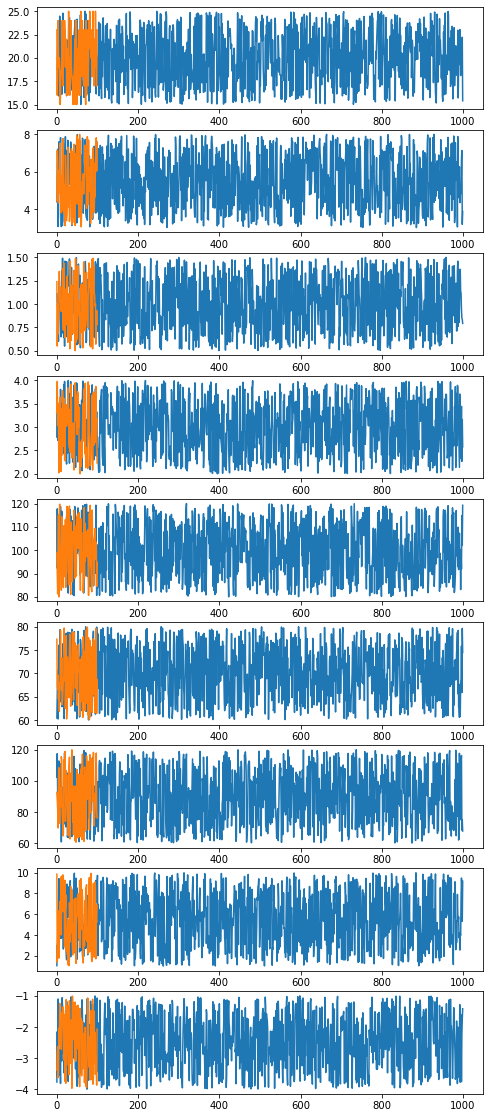

In [33]:
fig, axs = plt.subplots(9,1, figsize=(8,20))


for param, ax in zip(range(9), axs.flatten()):
    ax.plot(param_values[:,param])
    ax.plot(df_params.iloc[:, param])
    